In [1]:
# bring the cwd to the main folder
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
# import a bunch of stuff just in case
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd

In [3]:
from coordinate_utils import cartesian2polar

In [4]:
%matplotlib inline

In [8]:
MAZE = 'donut'
TEST_DATE = '11.09.2021'
AGENT_ID = 'hunt_10.29.21'

In [9]:
agent_path = os.path.join(os.getcwd(), 'agent_checkpoints/'+AGENT_ID)
data_path = os.path.join(agent_path,'run_'+TEST_DATE+'.pkl')

In [10]:
print(data_path)
df_donut = pd.read_pickle(data_path)

/Users/thinh/Sync/python-projects/echo_gym/echo_gym/bat_snake_env/agent_checkpoints/hunt_10.29.21/run_11.09.2021.pkl


In [7]:
print(data_path)
df_box = pd.read_pickle(data_path)

/Users/thinh/Sync/python-projects/echo_gym/echo_gym/bat_snake_env/agent_checkpoints/hunt_10.29.21/run_11.10.2021.pkl


### Statistic of result
1. Ending:
List of different possible endings:
- Success: <2 different types of success>
    - Intentional: ending score = 1 and azimuth <= 30
    - Luck: ending score = 1 and azimuth >30
- Wrongway: <2 differnt types of wrongway>
    - Naive, bat turns around before even get close to the food. ##
    - Bail last minute, bat get really close to the food but then bail last minute. ##
    - 

In [11]:
box_indexes = {'hit': None,
               'bail': None,
               'wrongway': None,
               'miss': None,
               'accidental': None,
               'intentional': None}

donut_indexes = {'hit': None,
               'bail': None,
               'wrongway': None,
               'miss': None,
               'accidental': None,
               'intentional': None}

In [12]:
box_indexes['hit'] = df_box[ df_box['scores']==-1 ].index.to_list()
donut_indexes['hit'] = df_donut[ df_donut['scores']==-1 ].index.to_list()

In [13]:
box_hit_rate = len(box_indexes['hit'])/len(df_box['scores'])
donut_hit_rate = len(donut_indexes['hit'])/len(df_donut['scores'])

In [14]:
print('Agent\'s hit rate in BOX maze = '+str(box_hit_rate*100)+' %')
print('Agent\'s hit rate in DONUT maze = '+str(donut_hit_rate*100)+' %')

Agent's hit rate in BOX maze = 18.0 %
Agent's hit rate in DONUT maze = 15.5 %


In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


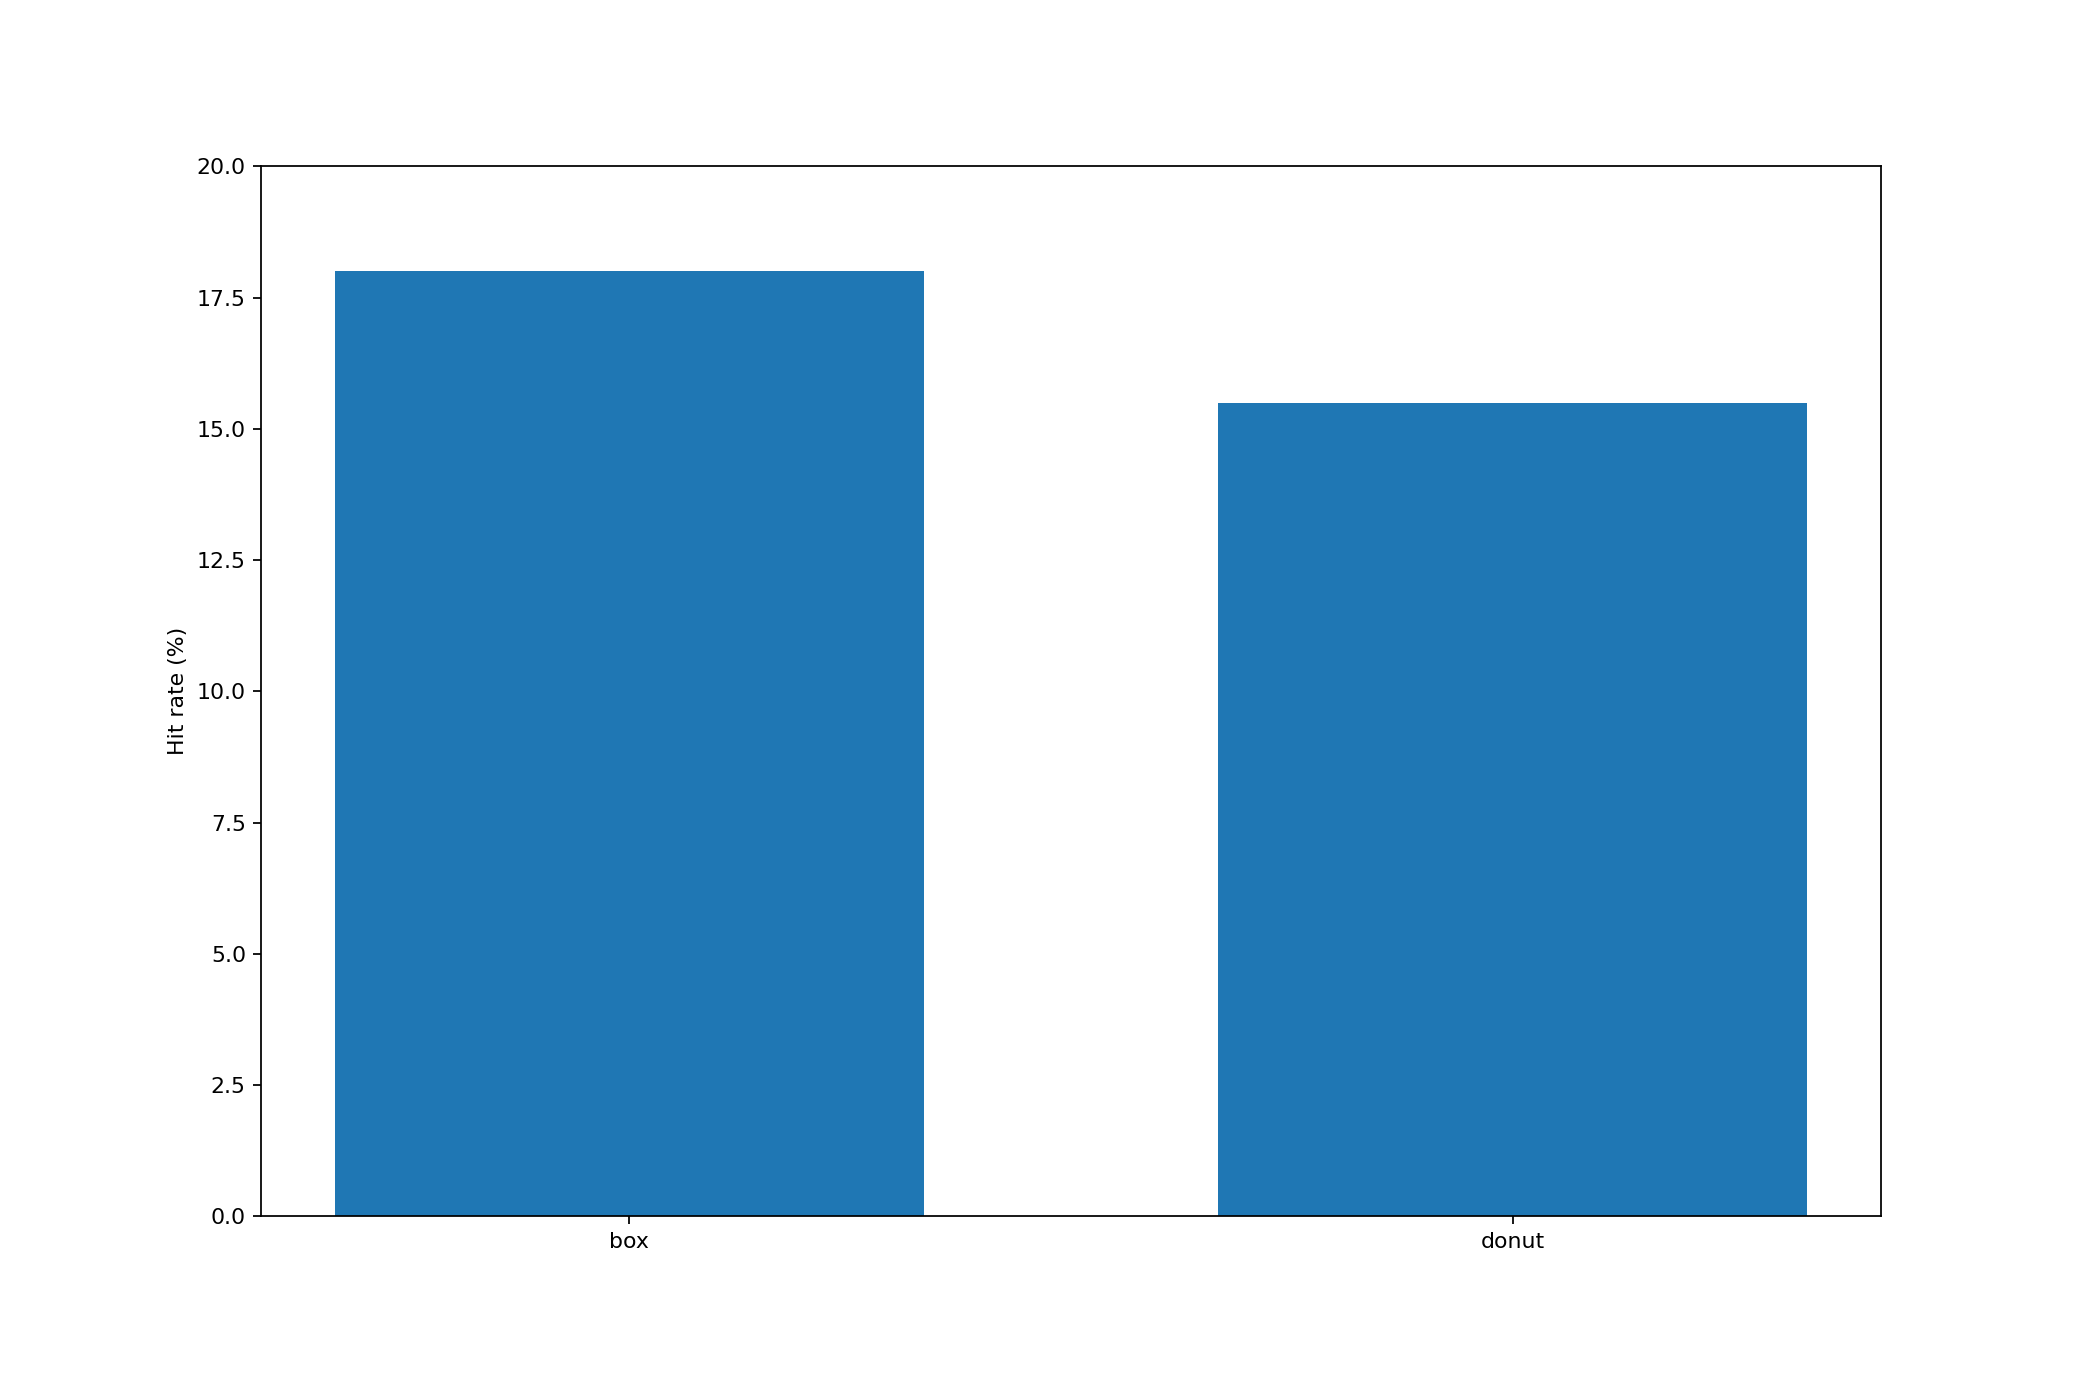

(0.0, 20.0)

In [16]:
bar_labels = ['box', 'donut']
x = 0.15*np.arange(len(bar_labels))
width = 0.1
fig1, ax1 = plt.subplots()
ax1.bar(x, [100*box_hit_rate, 100*donut_hit_rate], width)

ax1.set_ylabel('Hit rate (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(bar_labels)

ax1.set_ylim([0, 20])

#fig2.tight_layout()

In [17]:
box_safe_indexes = df_box[ df_box['scores']==0 ].index.to_list()
donut_safe_indexes = df_donut[ df_donut['scores']==0 ].index.to_list()

In [18]:
from coordinate_utils import polar_bat_reference

In [19]:
def label_diff_safe_cases(safe_indexes, data, bail_dist=1.5, bail_azi=30):
    wrongways = []
    misses = []
    bails = []
    others = []
    for i in safe_indexes:
        case_flag = None
        bats = data.at[i, 'bats']
        food = np.hstack((data.at[i, 'foods'][0], 1)).reshape(1,3)
        last_bat = bats[-1,:2]
        if last_bat[1] > 0:
            case_flag = 'miss'
        if last_bat[1] < 0:
            case_flag = 'wrongway'
        polar = np.array([]).reshape(0,2)
        for k in range(len(bats)):
            temp = polar_bat_reference(food, bats[k].reshape(1,3)).reshape(2,)
            temp[1] = temp[1] - bats[k][2]
            temp[1] = (temp[1]-360) if temp[1]>180 else temp[1]+360 if temp[1]<-180 else temp[1]
            polar = np.vstack((polar, temp))
        if np.sum((polar[:,0]<bail_dist)*(np.abs(polar[:,1])<bail_azi)):
            case_flag = 'bail'
            
        if case_flag == 'wrongway':
            wrongways.append(i)
        if case_flag == 'miss':
            misses.append(i)
        if case_flag == 'bail':
            bails.append(i)
        if case_flag == None:
            others.append(i)
    
    cases = {'wrongway': wrongways, 'miss': misses, 'bail': bails, 'other': others}
    
    return cases

In [20]:
def label_diff_hit_cases(hit_indexes, data, azi_lim = 45):
    intentional = []
    accidental = []
    for i in hit_indexes:
        case_flag = None
        bats = data.at[i, 'bats']
        last_bat = bats[-1]
        food = np.hstack(( data.at[i,'foods'][0], 1)).reshape(1,3)
        polar = polar_bat_reference(food, last_bat.reshape(1,3)).reshape(2,)
        polar[1] = polar[1] - last_bat[2]
        polar[1] = (polar[1]-360) if polar[1]>180 else polar[1]+360 if polar[1]<-180 else polar[1]
        
        if np.abs(polar[1])<azi_lim:
            intentional.append(i)
        else:
            accidental.append(i)
            
    cases = {'intentional': intentional, 'accidental': accidental}
    
    return cases

In [21]:
box_safe_cases = label_diff_safe_cases(box_safe_indexes, df_box)

In [22]:
donut_safe_cases = label_diff_safe_cases(donut_safe_indexes, df_donut)

In [23]:
box_hit_cases = label_diff_hit_cases(box_indexes['hit'], df_box)
donut_hit_cases=label_diff_hit_cases(donut_indexes['hit'], df_donut)

In [24]:
box_indexes['intentional'] = box_hit_cases['intentional']
box_indexes['accidental'] = box_hit_cases['accidental']
#
donut_indexes['intentional'] = donut_hit_cases['intentional']
donut_indexes['accidental'] = donut_hit_cases['accidental']

In [25]:
box_accidental_rate = len(box_indexes['accidental'])/len(df_box['scores'])
box_intentional_rate = len(box_indexes['intentional'])/len(df_box['scores'])
#
donut_accidental_rate = len(donut_indexes['accidental'])/len(df_donut['scores'])
donut_intentional_rate = len(donut_indexes['intentional'])/len(df_donut['scores'])

In [26]:
box_indexes['wrongway'] = box_safe_cases['wrongway']
box_indexes['miss'] = box_safe_cases['miss']
box_indexes['bail'] = box_safe_cases['bail']
#
donut_indexes['wrongway'] = donut_safe_cases['wrongway']
donut_indexes['miss'] = donut_safe_cases['miss']
donut_indexes['bail'] = donut_safe_cases['bail']

In [27]:
box_wrongway_rate = len(box_indexes['wrongway'])/len(df_box['scores'])
box_miss_rate = len(box_indexes['miss'])/len(df_box['scores'])
box_bail_rate = len(box_indexes['bail'])/len(df_box['scores'])
#
donut_wrongway_rate = len(donut_indexes['wrongway'])/len(df_donut['scores'])
donut_miss_rate = len(donut_indexes['miss'])/len(df_donut['scores'])
donut_bail_rate = len(donut_indexes['bail'])/len(df_donut['scores'])

In [28]:
print('Agent\'s intentional hit rate in BOX maze = '+str(box_intentional_rate*100)+' %')
print('Agent\'s accidental hit rate in BOX maze = '+str(box_accidental_rate*100)+' %')
print('Agent\'s miss rate in BOX maze = '+str(box_miss_rate*100)+' %')
print('Agent\'s bail rate in BOX maze = '+str(box_bail_rate*100)+' %')
print('Agent\'s wrongway rate in BOX maze = '+str(box_wrongway_rate*100)+' %')
#
print('Agent\'s intentional hit rate in DONUT maze = '+str(donut_intentional_rate*100)+' %')
print('Agent\'s accidental hit rate in DONUT maze = '+str(donut_accidental_rate*100)+' %')
print('Agent\'s miss rate in DONUT maze = '+str(donut_miss_rate*100)+' %')
print('Agent\'s bail rate in DONUT maze = '+str(donut_bail_rate*100)+' %')
print('Agent\'s wrongway rate in DONUT maze = '+str(donut_wrongway_rate*100)+' %')

Agent's intentional hit rate in BOX maze = 0.8999999999999999 %
Agent's accidental hit rate in BOX maze = 17.1 %
Agent's miss rate in BOX maze = 6.7 %
Agent's bail rate in BOX maze = 74.8 %
Agent's wrongway rate in BOX maze = 0.5 %
Agent's intentional hit rate in DONUT maze = 0.4 %
Agent's accidental hit rate in DONUT maze = 15.1 %
Agent's miss rate in DONUT maze = 7.3 %
Agent's bail rate in DONUT maze = 77.0 %
Agent's wrongway rate in DONUT maze = 0.2 %


In [ ]:
box_indexes['accidental']

In [ ]:
donut_indexes['accidental']

<IPython.core.display.Javascript object>


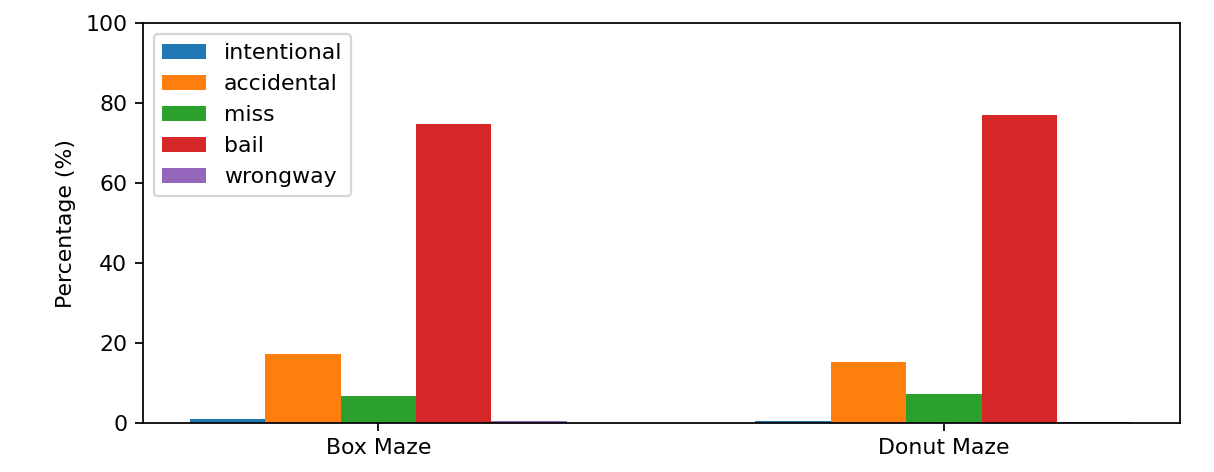

In [47]:
%matplotlib notebook
bar_labels = ['Box Maze', 'Donut Maze']

intentional_rates = [100*box_intentional_rate, 100*donut_intentional_rate]
accidental_rates = [100*box_accidental_rate, 100*donut_accidental_rate]
miss_rates = [100*box_miss_rate, 100*donut_miss_rate]
bail_rates = [100*box_bail_rate, 100*donut_bail_rate]
wrongway_rates = [100*box_wrongway_rate, 100*donut_wrongway_rate]

x = 1.5*np.arange(len(bar_labels))
width = 0.2
fig2, ax2 = plt.subplots()

ax2.bar(x - 2.*width, intentional_rates, width, label='intentional')
ax2.bar(x - 1*width, accidental_rates, width, label='accidental')
ax2.bar(x , miss_rates, width, label='miss')
ax2.bar(x + 1*width, bail_rates, width, label='bail')
ax2.bar(x + 2*width, wrongway_rates, width, label='wrongway')

ax2.set_ylabel('Percentage (%)')
ax2.set_xticks(x)
ax2.set_xticklabels(bar_labels)
ax2.legend(loc='upper left')
ax2.set_ylim([0, 100])

fig2.tight_layout()

For box maze, let try to plot the maze again with scatter

In [ ]:
%matplotlib inline

In [ ]:
df_box.at[0,'obstacles'][:,0]

In [ ]:
box_obstacles = df_box.at[0,'obstacles'][:,:2].reshape(-1,2)
donut_obstacles = df_donut.at[0,'obstacles'][:,:2].reshape(-1,2)

In [ ]:
df_box.loc[19]

In [ ]:
box_success_foods = np.array([]).reshape(0,2)
for i in box_indexes['success']:
    print(i)
    box_success_foods = np.vstack((box_success_foods, df_box.at[i, 'foods'][0]))
box_miss_foods = np.array([]).reshape(0,2)
for i in box_indexes['miss']:
    box_miss_foods = np.vstack((box_miss_foods, df_box.at[i, 'foods'][0]))
box_bail_foods = np.array([]).reshape(0,2)
for i in box_indexes['bail']:
    box_bail_foods = np.vstack((box_bail_foods, df_box.at[i, 'foods'][0]))
box_wrongway_foods = np.array([]).reshape(0,2)
for i in box_indexes['wrongway']:
    box_wrongway_foods = np.vstack((box_wrongway_foods, df_box.at[i, 'foods'][0]))


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(box_obstacles[:,0], box_obstacles[:,1],s=200, c='g', marker='*')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(donut_obstacles[:,0], donut_obstacles[:,1],s=200, c='g', marker='*')

In [ ]:
run_indexes = {'success': None,
               'bail': None,
               'wrongway': None,
               'miss': None,
               'intentional': None,
               'luck': None}

In [ ]:
run_indexes['success'] = df[df['scores']==1].index.to_list()

In [ ]:
print(len(df[df['returns']==2].index.to_list()))

In [ ]:
run_indexes['unregistered_success'] = [ 19,  58, 184, 187, 190, 206, 261, 271, 276, 279,
                                       333, 340, 392, 496, 517, 539, 554, 635, 712, 751,
                                       762, 785, 800, 807, 812, 839] # for box

In [ ]:
run_indexes['unregistered_success'] = [ 46,  70,  98, 107, 115, 151, 161, 168, 212, 266,
                                       301, 399, 402, 410, 436, 443, 444, 453, 457, 469, 
                                       470, 490, 553, 572, 573, 574, 589, 641, 642, 652, 
                                       663, 668, 685, 705, 749, 782, 823, 843, 866, 877,
                                       887, 924, 926, 934, 976, 987, 995, 998] # for donut

In [ ]:
for i in run_indexes['unregistered_success']:
    if df.at[i, 'scores'] != 1:
        df.at[i, 'scores'] = 1
    else:
        print('score was already ' + str(df.at[i, 'scores']))
    
    if df.at[i, 'returns'] != 2:
        df.at[i, 'returns'] = 2
    else:
        print('return was already ' + str(df.at[i, 'returns']))

In [ ]:
df.keys()

In [ ]:
unreg_foods = []
for i in run_indexes['unregistered_success']:
    unreg_foods.append(df.at[i, 'foods'])

In [ ]:
unreg_bats = []
for i in run_indexes['unregistered_success']:
    unreg_bats.append(df.at[i, 'bats'])

In [ ]:
unreg_echoes = []
for i in run_indexes['unregistered_success']:
    unreg_echoes.append(df.at[i, 'echoes'])

In [ ]:
unreg_strategies = []
for i in run_indexes['unregistered_success']:
    unreg_strategies.append(df.at[i, 'strategies'])

In [ ]:
unreg_iids = []
for i in run_indexes['unregistered_success']:
    unreg_iids.append(df.at[i, 'iids'])

In [ ]:
unreg_moves = []
for i in run_indexes['unregistered_success']:
    unreg_moves.append(df.at[i, 'moves'])

In [ ]:
unreg_turns = []
for i in run_indexes['unregistered_success']:
    unreg_turns.append(df.at[i, 'turns'])

In [ ]:
unreg_values = []
for i in run_indexes['unregistered_success']:
    unreg_values.append(df.at[i, 'value_layers'])

For each unregister episode:
- Create the polar np.array, shape=(n,2), with distance and azimuth
- Stack in a polar list

In [ ]:
from coordinate_utils import polar_bat_reference
unreg_polars = []
for i, bat in enumerate(unreg_bats):
    temp_polar = np.array([]).reshape(0,2)
    for k in range(len(bat)):
        temp = polar_bat_reference(np.hstack((unreg_foods[0][0],1)).reshape(1,3),
                                   bat[k].reshape(1,3)).reshape(2,)
        temp[1] = temp[1] - bat[k][2]
        temp[1] = (temp[1]-360) if temp[1]>180 else temp[1]+360 if temp[1]<-180 else temp[1]
        temp_polar = np.vstack((temp_polar, temp))  

    unreg_polars.append(temp_polar)

In [ ]:
new_bats = []
new_foods = []
new_echoes = []
new_strategies = []
new_iids = []
new_moves = []
new_turns = []
new_values = []
new_polars = []
for i, polar in enumerate(unreg_polars):
    temp_bats = unreg_bats[i]
    temp_foods = unreg_foods[i]
    temp_echoes = unreg_echoes[i]
    temp_strategies = unreg_strategies[i]
    temp_iids = unreg_iids[i]
    temp_moves = unreg_moves[i]
    temp_turns = unreg_turns[i]
    temp_values = unreg_values[i]
    temp_polars = unreg_polars[i]
    
    distances = unreg_polars[i][:,0]
    azimuths = np.abs(unreg_polars[i][:,1])
    stop_idx = np.argmax((distances < 0.4)*(azimuths < 45)) + 1
    
    new_bats.append(temp_bats[:stop_idx])
    new_foods.append(temp_foods[:stop_idx])
    new_echoes.append(temp_echoes[:stop_idx])
    new_strategies.append(temp_strategies[:stop_idx])
    new_iids.append(temp_iids[:stop_idx])
    new_moves.append(temp_moves[:stop_idx])
    new_turns.append(temp_turns[:stop_idx])
    new_values.append(temp_values[:stop_idx])
    new_polars.append(temp_polars[:stop_idx])

In [ ]:
for i, index in enumerate(run_indexes['unregistered_success']):
    df.at[index, 'bats'] = new_bats[i]
    df.at[index, 'foods'] = new_foods[i]
    df.at[index, 'echoes'] = new_echoes[i]
    df.at[index, 'strategies'] = new_strategies[i]
    df.at[index, 'iids'] = new_iids[i]
    df.at[index, 'moves'] = new_moves[i]
    df.at[index, 'turns'] = new_turns[i]
    df.at[index, 'value_layers'] = new_values[i]
    

In [ ]:
df.to_pickle('agent_checkpoints/hunt_10.29.21/run_11.07.2021.A.pkl')

In [ ]:
for i in range(len(unreg_polars)):
    plt.plot(unreg_polars[i][:,0])

In [ ]:
for i in range(len(new_polars)):
    plt.plot(new_polars[i][:,0])

In [ ]:
np.sum(df['scores'])

In [ ]:
miss_run = df['bats'][df['scores'] == 0]

In [ ]:
np.sum(df['returns'] <0)

In [ ]:
miss_run_idx = np.array(miss_run.index.to_list())

In [ ]:
miss_run = miss_run.to_list()

In [ ]:
miss_run[0][-1,:2]

In [ ]:
miss_run_idx.shape

In [ ]:
miss = np.zeros(miss_run_idx.shape)
for i, run in enumerate(miss_run):
    last_bat = run[-1, :2]
    if last_bat[0] > 0:
        miss[i] = 1


In [ ]:
print(miss_run_idx[miss == 1].tolist()[:10])
print(miss_run_idx[miss == 1].tolist()[10:20])
print(miss_run_idx[miss == 1].tolist()[20:30])
print(miss_run_idx[miss == 1].tolist()[30:40])
print(miss_run_idx[miss == 1].tolist()[40:50])
print(miss_run_idx[miss == 1].tolist()[50:60])
print(miss_run_idx[miss == 1].tolist()[60:])